## Level Set Method for Image Segmentation

The method is based on the paper **Retina Image Vessel Segmentation Using a Hybrid CGLI Level Set Method** by Chen et al.

**Note:** The Gaussian convolution used in the paper is replaced with a heat equation using FFT.

In [1]:
%load_ext autoreload

# Import libararies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.fftpack import dct, idct # for Fourier transforms
from nptyping import NDArray, Float64
from lsm import *
from scipy.ndimage.filters import gaussian_filter # For a Gaussian blur

In [2]:

# A function that runs the level set method with a given image.
def run_lsm(image, lsm, step_size=1, max_iter=10, print_every=10, do_plot=True):

    
    for outer_iter in range(max_iter):
        # initianlize phi
        lsm.phi[lsm.phi<0]  =  -lsm.rho
        lsm.phi[lsm.phi>=0] =   lsm.rho

        # apply heat equation
        lsm.phi = lsm.conv(lsm.phi)

        # compute f1 and f2
        lsm.compute_local_bin_value(image)

        # compute c1 and c2
        lsm.compute_the_region_average_intensity(image)

        # Compute Spf
        lsm.compute_the_local_global_force(image)

        # compute |\nabla phi|
        lsm.compute_absolute_gradient()

        # update phi
        lsm.update_phi(step_size, image)
        
        # print iteration and show images if do_plot == True
        if(outer_iter % print_every == 0):
            print("Iter: {:3d}".format(outer_iter))
            if do_plot:
                fig,ax = plt.subplots(1,2,figsize=(10,5))
                ax[0].imshow(image, 'bone')
                ax[0].set_title("Image")
                ax[1].contour(np.flipud(lsm.phi),[0])
                ax[1].set_title("iter: {:3d}".format(outer_iter))
                plt.tight_layout()
                plt.show()
    return lsm.phi

## Setting the parameters

In [3]:
# Define parameters
n1 = 1024
n2 = 1024

# Paramters for a level set method
rho = 1        # No need to modify this. It doesn't affect the result very much.
sigma   = 1e-7 # A parameter for a convolution. Higher the value, lesser the noise and lower the accuracy.
omega   = 0.2  # A ratio of gG and gL functions. gL + omega * gG.
epsilon = 0.2  # A paramter for a H_epsilon function.

## Create a lsm object

In [4]:
# Create a lsm object
lsm = LSM(n1,n2,rho,sigma,omega,epsilon)

## Import and preprocess images

Here we import the image from outside. We resize the image to **(n2, n1)** (n1 and n2 are user-specified inputs).

It converts the RGB image into a gray scale image and apply a Gaussian blur to smooth the image.

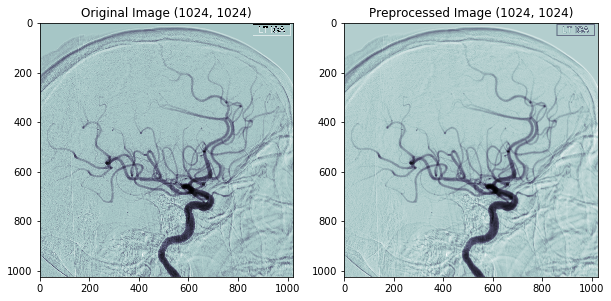

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Import an image
# image = mpimg.imread('./external_images/74al.png')
# image = mpimg.imread('./external_images/51al.png')
original_image = mpimg.imread('./external_images/66bl.png')

ax[0].imshow(original_image,'bone')
ax[0].set_title("Original Image {}".format(original_image.shape))

image = cv2.resize(original_image, (n2,n1))

if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gaussian_sigma = 1
    
image = gaussian_filter(image, sigma=gaussian_sigma)

ax[1].imshow(image,'bone')
ax[1].set_title("Preprocessed Image {}".format(image.shape))
    

plt.show()

Iter:   0


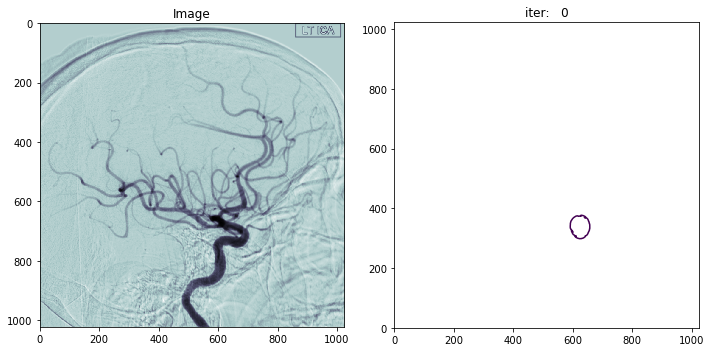

Iter: 100


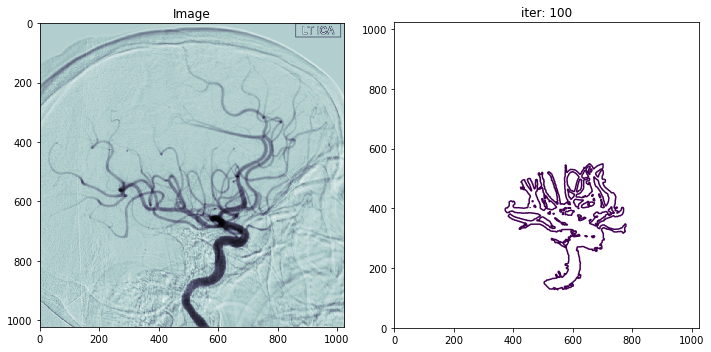

Iter: 200


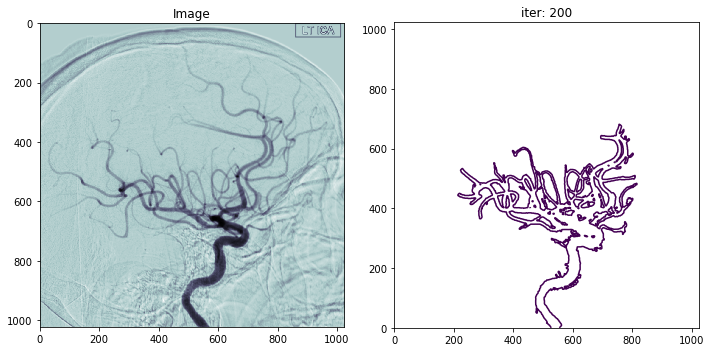

Iter: 300


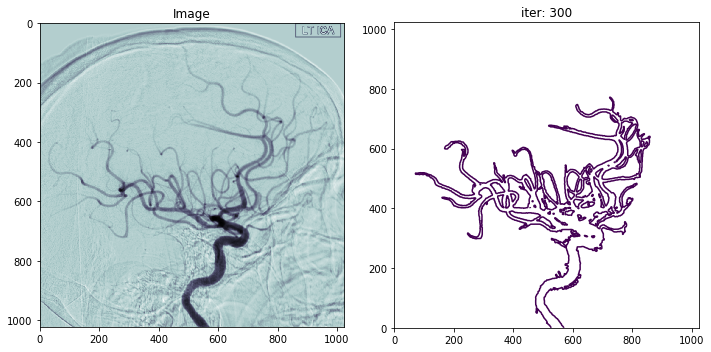

Iter: 400


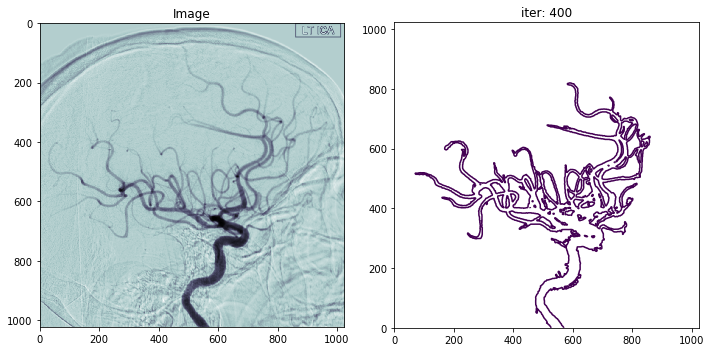

Iter: 500


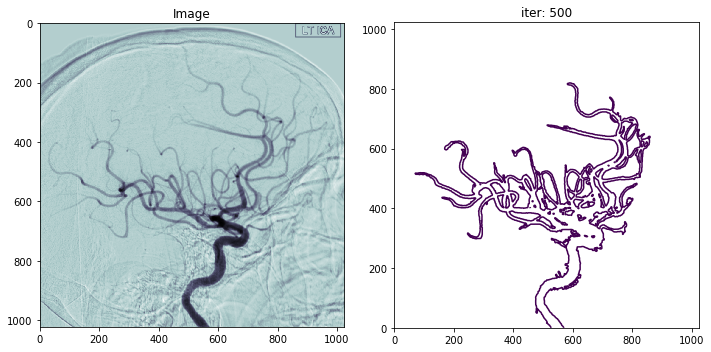

In [6]:
# Run a method
max_iter = 600 # Maximum iterations
print_every = 100 # Verbose. Print every [print_every] iteration.
step_size = 500 # step size of the method

# initailize phi based on an image.
# It will find the center of mass using a smoothing method.
lsm.initialize_phi(image)

# Run a method.
phi = run_lsm(image, lsm, step_size=step_size, max_iter=max_iter, print_every=print_every, do_plot=True)

## Potting the result

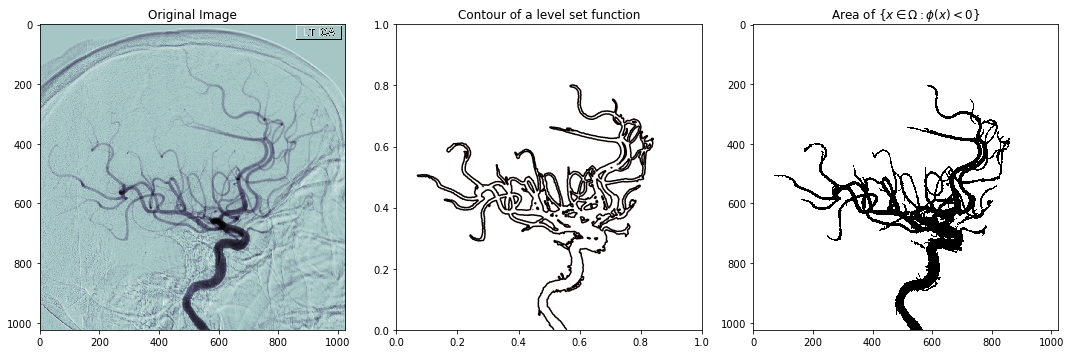

In [7]:
newim = np.zeros_like(phi)
phinew = lsm.conv(phi, 1e-7)
newim[phinew<0]= 1

x = np.linspace(0.5/n1, 1 - 0.5/n1, n1)
y = np.linspace(0.5/n2, 1 - 0.5/n2, n2)

x, y = np.meshgrid(x,y)

# Plot the result
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(original_image, 'bone')
ax[0].set_title("Original Image")
ax[1].contour(x,y,np.flipud(phinew), [0], cmap='hot')
ax[1].set_title("Contour of a level set function")

ax[2].imshow(newim, cmap='bone')
ax[2].set_title("Area of $\\{ x \\in \\Omega: \\phi(x) < 0 \\}$")
plt.tight_layout()
plt.show()